In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
sample_1 = loadmat('sample_1.mat')

In [59]:
sample_1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'samplingInterval', 'startData', 'chan', 'data', 'spike_times', 'spike_class'])

In [60]:
samplingInterval = sample_1['samplingInterval'][0,0]
startData = sample_1['startData'][0,0]
chan = sample_1['chan'][0,0]
data = sample_1['data'][0]
spike_times = sample_1['spike_times'][0,0][0]
spike_class = sample_1['spike_class'][0,0][0]

np.unique(spike_class)

array([0, 1, 2], dtype=uint8)

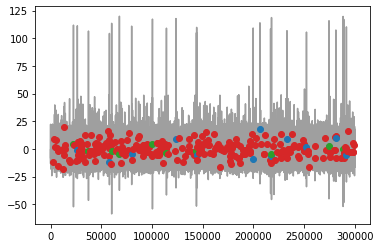

In [5]:
t_max = 300000
plt.plot(data[:t_max],zorder=1,c = '#9f9f9f')
i = 0

c_map = {0:'#d62728',1:'#2ca02c',2:'#1f77b4'}

while (spike_times[i]<t_max):
    plt.scatter(spike_times[i],data[spike_times[i]],c=c_map[spike_class[i]],zorder=2)
    i+=1

0

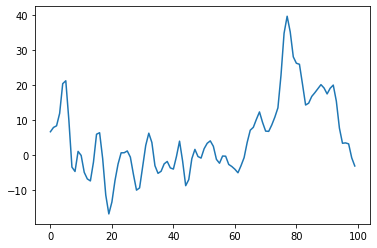

In [6]:
plt.plot(data[spike_times[2]-50:spike_times[2]+50])
spike_class[2]

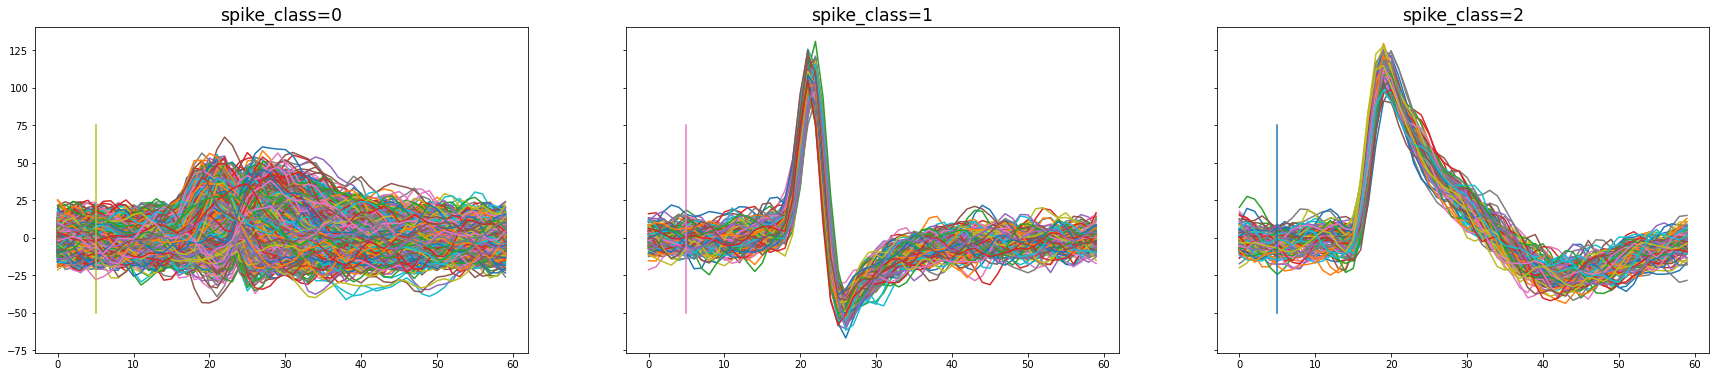

In [7]:
fig,axs = plt.subplots(1,3,figsize=(30,6),sharey=True)
for j,ax in enumerate(axs):
    for i in range(1,len(spike_class)):
        if spike_class[i] == j:
            ax.plot(data[spike_times[i]:spike_times[i]+60])
    ax.plot([5,5],[-50,75])
    ax.title.set_text('spike_class='+str(j))
    ax.title.set_size('xx-large')

In [8]:
len(spike_class)

2415

### Detect spikes

In [10]:
sigma = lambda x: np.median(np.abs(x)/.6745)
threshold = sigma(data)

In [65]:
def spikeTimeSelect(arr,t):
    # 50 ms
    new_spikes = [0]
    temp = []
    for i in range(len(arr)-1):
        temp.append(arr[i])

        if not (arr[i] == arr[i+1]-1):
            new_val = int(np.median(temp))
            if (np.abs(new_spikes[-1]-new_val)> t):
                new_spikes.append(new_val)
                temp = []
    return new_spikes[1:]
np.array(spikeTimeSelect(np.where(data>=(4*threshold))[0],70))[:10]

array([ 1146,  2040,  5950,  7016,  8136, 11669, 11811, 12077, 12897,
       14258])

In [64]:
def detectSpikes(arr,sd=6):
    spk_indcs = np.where(data>=(sd*sigma(arr)))[0]
    consec_nums = []
    out = []

    for i in range(len(spk_indcs)-1):

        if (spk_indcs[i]+1 == spk_indcs[i+1]):
            consec_nums.append(spk_indcs[i])
            
        elif consec_nums:
            t_max = 0
            for j in consec_nums:
                if arr[j]>=arr[t_max]:
                    t_max = j    
            out.append(t_max)
            consec_nums = []
        else:
            out.append(spk_indcs[i])
    return out  

spike_indeces = detectSpikes(data,6)


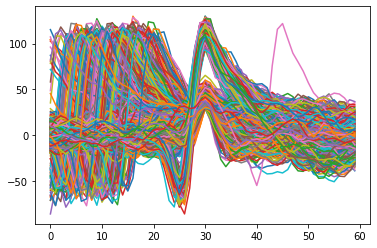

In [62]:
for i in range(len(spike_indeces)):
    plt.plot(data[spike_indeces[i]-30:spike_indeces[i]+30])

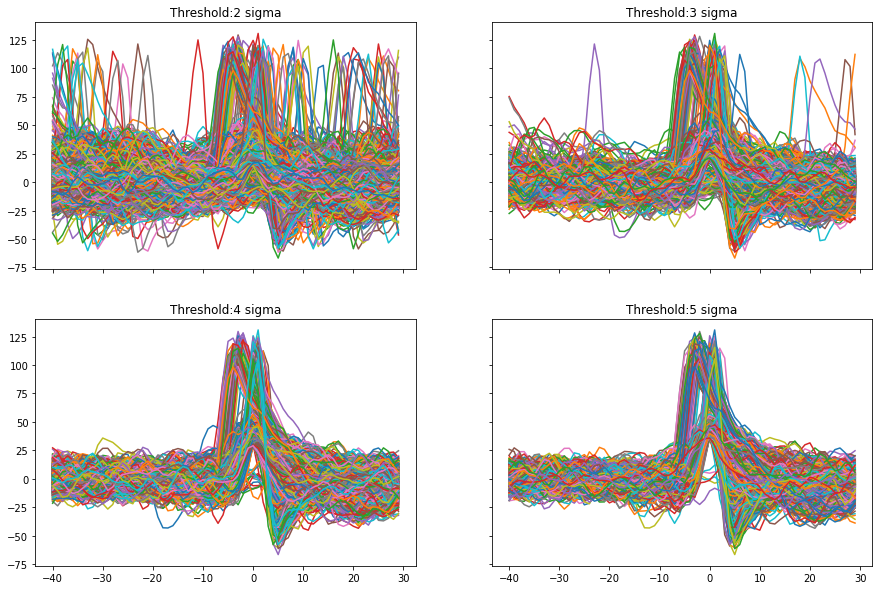

In [26]:
# see det 
fig, axs = plt.subplots(2,2,sharex=True,sharey=True,figsize=(15,10))
x_ticks = np.arange(-40,30,1)
j = 1
for axs_ in axs:
    for ax in axs_:
        
        j+=1
        det_spike_times = np.array(spikeTimeSelect(np.where(data>=(j*threshold))[0],20))
        
        for i in range(len(det_spike_times)):
            ax.plot(x_ticks,data[det_spike_times[i]-40:det_spike_times[i]+30])
            ax.set_title(f"Threshold:{j} sigma")

In [27]:
len(np.array(spikeTimeSelect(np.where(data>=(3.4*threshold))[0],70))),len(spike_class)

(2417, 2415)

### Identify spikes

In [28]:
det_spike_times = np.array(spikeTimeSelect(np.where(data>=(3.4*threshold))[0],70))

det_spikes = list()
for spike_time in det_spike_times:
    det_spikes.append(data[spike_time-40:spike_time+30])
det_spikes = np.array(det_spikes)

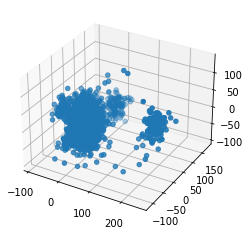

In [29]:
from sklearn.decomposition import PCA

# 0.9, as it is recommended to keep 90% 
# of variance in the data after PCA
pca = PCA(0.9)
pca_fit = pca.fit_transform(det_spikes)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_fit[:,0],pca_fit[:,1],pca_fit[:,2])

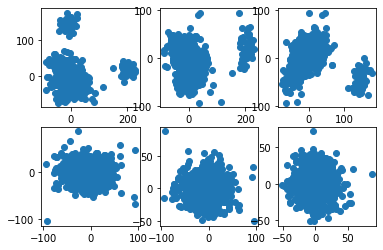

In [30]:
fig, axs = plt.subplots(2,3)
axs[0,0].scatter(pca_fit[:1000,0],pca_fit[:1000,1])
axs[0,1].scatter(pca_fit[:1000,0],pca_fit[:1000,2])
axs[0,2].scatter(pca_fit[:1000,1],pca_fit[:1000,2])
axs[1,0].scatter(pca_fit[:1000,2],pca_fit[:1000,3])
axs[1,1].scatter(pca_fit[:1000,2],pca_fit[:1000,4])
axs[1,2].scatter(pca_fit[:1000,4],pca_fit[:1000,5])

In [31]:
from sklearn.cluster import KMeans
km_pred = KMeans(n_clusters=3).fit_predict(det_spikes)


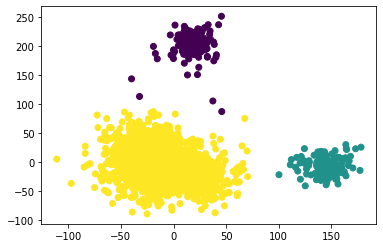

In [32]:
plt.scatter(pca_fit[:,1],pca_fit[:,0],c=km_pred)

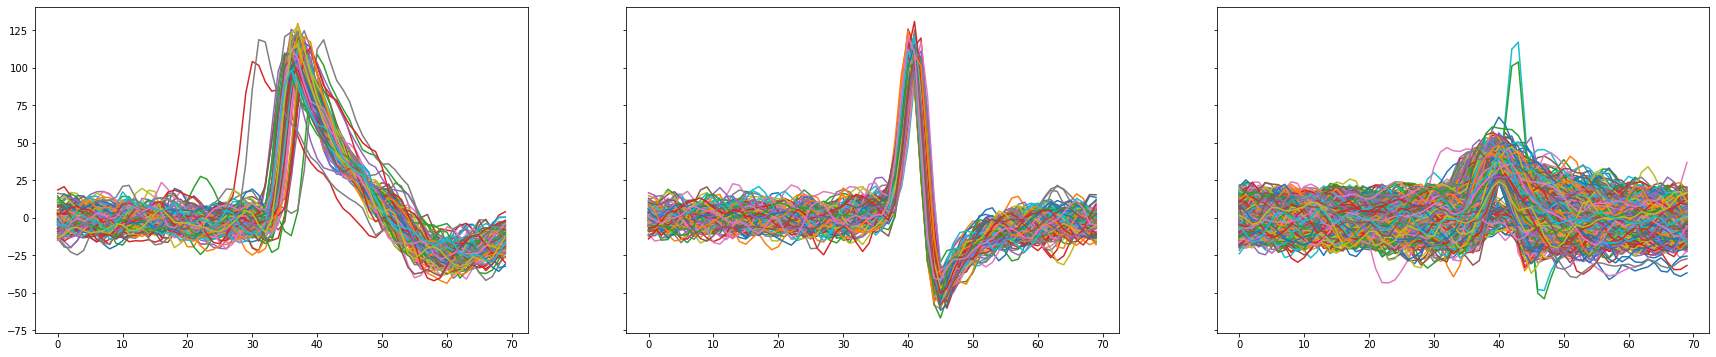

In [33]:
n_classes = len(np.unique(km_pred))
fig,ax = plt.subplots(1,n_classes,figsize=(30,6),sharey=True)
for j in range(n_classes):
    for i,el in enumerate(km_pred):
        if el == j:
            ax[j].plot(det_spikes[i])

In [34]:
print(len(km_pred),len(spike_class))
print("km_pred",len(np.where(km_pred==0)[0]),len(np.where(km_pred==1)[0]),len(np.where(km_pred==2)[0]),"\n"
      "true",len(np.where(spike_class==0)[0]),len(np.where(spike_class==1)[0]),len(np.where(spike_class==2)[0]))

2417 2415
km_pred 110 117 2190 
true 2179 126 110
